In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from src.adaboost import AdaBoost
import src.utils as utils

In [2]:
df = pd.read_csv("data/diamonds.csv")
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)

In [4]:
param_grid = {
	"n_estimators": [50, 100, 200],
	"learning_rate": [0.1, 1, 5, 10],
	"algorithm": ["SAMME", "SAMME.R"]
}

grid_search = GridSearchCV(AdaBoost(), param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=AdaBoost(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 1, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [5]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.7291798776370959,
  {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 200}),
 (0.725192467926906,
  {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}),
 (0.7238812091740059,
  {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}),
 (0.7134981052652989,
  {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 100}),
 (0.7121869252903352,
  {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 200}),
 (0.7073698406762785,
  {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 50}),
 (0.7066205801414931,
  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 200}),
 (0.7059781782967429,
  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}),
 (0.6987795149148297,
  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}),
 (0.6331356221976315,
  {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 50}),
 (0.62566938597361,
  {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 10

We observe that the SAMME `algorithm` performs better than SAMME.R, and the best `learning_rate` is 1.0. From the random forest, we already know that by increasing `max_depth` we increase the value of the metrics, and that it's irrelevant to choose 100 or 200 `n_estimators`, so we choose 100 that is computationally cheaper.

Note: we perform Grid Search instead of Randomized Search because we want to ensure all combinations are made, so that we can see clear relations between parameters if there exist (we weren't able to find any).

In [6]:
model = AdaBoost(n_estimators=100, max_depth=4, learning_rate=1.0, algorithm="SAMME")
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.7160824190527161,
 'precision': 0.6381578947368421,
 'recall': 0.6319218241042345,
 'f1': 0.6350245499181669}

In [7]:
result_df = pd.DataFrame({"y_val": y_val, "y_pred": model.predict(X_val)})
result_counts = result_df.apply(pd.Series.value_counts)
result_counts

,y_val,y_pred
4,3223,3607
3,1927,2008
2,1674,1211
1,614,608
0,36,40


Unlike Random Forest, AdaBoost doesn't need balanced class weigths, the frequency of each class in the prediction is already proportional to the one in the training set.

Now we increase the `max_depth` as we did with Random Forest.

In [8]:
model = AdaBoost(n_estimators=100, max_depth=15, learning_rate=1.0, algorithm="SAMME")
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.7757559539737757,
 'precision': 0.8003913894324853,
 'recall': 0.6661237785016286,
 'f1': 0.7271111111111112}

As expected, all metrics have increased as the model complexity increased. Finally, we test the model.

In [9]:
model1 = AdaBoost(n_estimators=100, max_depth=15, learning_rate=1.0, algorithm="SAMME")
model1.fit(X_train, y_train)
model1.compute_metrics(X_test, y_test)

{'accuracy': 0.7829158638407193,
 'precision': 0.8117443868739206,
 'recall': 0.6403269754768393,
 'f1': 0.7159177456207161}

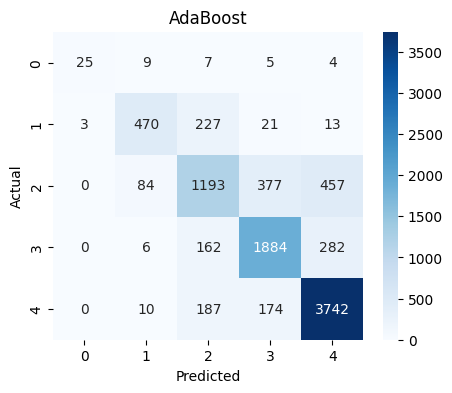

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = model1.conf_matrix(X_test, y_test)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("AdaBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
from src.randomforest import RandomForest
model2 = RandomForest(n_estimators=100, max_depth=16, bootstrap=True, class_weight="balanced")
model2.fit(X_train, y_train)
diff = model1.compare(model2, X_test, y_test)

accuracy 0.0021408691928922474
precision 0.03464515023269921
recall -0.053133514986375974
f1 -0.016983622269852616
confusion matrix [[  -4    2    3   -1    0]
 [   1  -39   44  -12    6]
 [   0  -31  167 -129   -7]
 [   0   -5   54  -51    2]
 [   0   -3   67  -11  -53]]


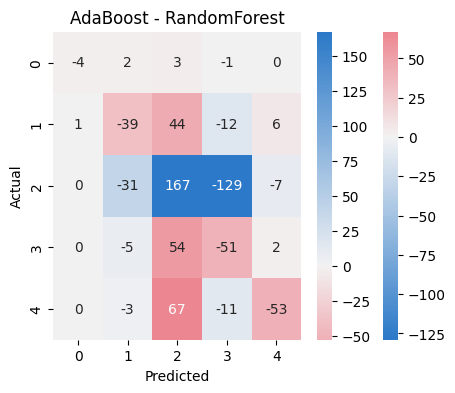

In [12]:
import numpy as np

conf_mat_diff = diff["confusion matrix"]

mask = np.eye(conf_mat_diff.shape[0], dtype=bool)
cmap_diag = sns.diverging_palette(250, 10, s=90, l=50, as_cmap=True)
cmap_offdiag = sns.diverging_palette(10, 250, s=90, l=50, as_cmap=True)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_diff, mask=mask, annot=True, fmt="d", cmap=cmap_diag, center=0)
sns.heatmap(conf_mat_diff, mask=~mask, annot=True, fmt="d", cmap=cmap_offdiag, center=0)
plt.title("AdaBoost - RandomForest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Colors meaning: Blue means better; red means worse. Normally we want higher values in the diagonal, but we got less with AdaBoost than with Random Forest, that's why it's red. For the rest of the matrix, we want lower values.

Looking by rows, we observe that the precision lost in all classes is gained in class 2 (the actual class 2 is predicted with more precision, while other classes are wrongly predicted as class 2 more often).

In [13]:
result_df = pd.DataFrame({"y_test": y_test, "y_pred": model1.predict(X_test)})
result_counts = result_df.apply(pd.Series.value_counts)
result_counts

,y_test,y_pred
4,4113,4498
3,2334,2461
2,2111,1776
1,734,579
0,50,28


Overall, AdaBoost performed worse than Random Forest. The only metric that increased was precision, which we dismiss because we saw it was because of a trend of the model in predicting class 2 more than others compared to Random Forest.